In [ ]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import seaborn as sns
import torch
import csv
import pandas as pd
import ast
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from collections import defaultdict

# Download And Load the Model

In [ ]:
model = SentenceTransformer("thenlper/gte-large")
#Run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Test the Model With a Text

In [ ]:
text = "Apple shares rallied after the company posted record earnings."
embedding = model.encode(text)
print(embedding)
print(type(embedding))
print(len(embedding))


[-0.0176754   0.01342189 -0.01475552 ... -0.02928481 -0.01131905
 -0.00817733]
<class 'numpy.ndarray'>
1024


This model is much heavier than the FinBERT one. Therefore, we should use batch processing to make the embeddings' generation faster.

In [ ]:

# Example sentences
sentences = [
    "This is an example sentence.",
    "Each sentence is converted to an embedding.",
    "Embeddings can be used for various NLP tasks.",
    "GPUs accelerate deep learning computations.",
    "The GTE-large model produces 1024-dimensional embeddings."
]

# Generate embeddings on GPU
embeddings = model.encode(
    sentences,
    normalize_embeddings=True,
    convert_to_tensor=True,  # Keep tensors on GPU
    batch_size=32,  # Adjust based on your GPU memory
    show_progress_bar=True
)

# Convert to numpy if needed (this will move to CPU)
embeddings_np = embeddings.cpu().numpy()

print(f"Embeddings shape: {embeddings_np.shape}")
print(f"First embedding (first 10 dims): {embeddings_np[0][:10]}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (5, 1024)
First embedding (first 10 dims): [-0.0155556  -0.01812899  0.00258631  0.00301443 -0.01894457 -0.01741451
 -0.00830965  0.01310531  0.02830398  0.03369889]


# Generate Embeddings (Run the model on data)

In [ ]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

BATCH_SIZE = 256  # Adjust based on GPU memory (try 64, 128, 256, 512)


df = pd.read_csv("Clustering_Dataset.csv")
texts = df["text"].tolist()  # Convert to list for faster iteration

def batch_encode(texts, model, batch_size=BATCH_SIZE):
    """Process texts in batches with error handling"""
    all_embeddings = []
    failed_indices = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i + batch_size]

        try:
            with torch.no_grad():  # Disable gradient for memory efficiency
                batch_emb = model.encode(
                    batch,
                    normalize_embeddings=True,
                    convert_to_numpy=True,  # Return numpy array instead of tensor
                    show_progress_bar=False
                )
            all_embeddings.extend(batch_emb.tolist())
        except Exception as e:
            # If batch fails, process items individually
            print(f"Batch failed, processing individually (error: {str(e)})")
            for text in batch:
                try:
                    emb = model.encode(
                        text,
                        normalize_embeddings=True,
                        convert_to_numpy=True
                    )
                    all_embeddings.append(emb.tolist())
                except:
                    all_embeddings.append([None])
                    failed_indices.append(i)

    return all_embeddings, failed_indices

# Process all texts in optimized batches
embeddings, failed_indices = batch_encode(texts, model)

# Add to DataFrame
df["embedding"] = embeddings

# Save results
df.to_csv("Clustering_Embeddings.csv", index=False)

# Print summary
print(f"Done! Processed {len(df) - len(failed_indices)}/{len(df)} successfully")
if failed_indices:
    print(f"Failed on {len(failed_indices)} items (indices: {failed_indices})")

Generating embeddings: 100%|██████████| 111/111 [16:08<00:00,  8.73s/it]


✅ Done! Processed 28199/28199 successfully


# CLUSTERING

### Read the Embeddings from the Clustering_Embeddings.csv file

In [ ]:
df = pd.read_csv("Clustering_Embeddings.csv")
texts = df["text"].tolist()  # Convert to list for faster iteration
embeddings = df["embedding"].apply(ast.literal_eval).tolist()

### Prepare data for clustering

In [ ]:
valid_embeddings = np.array([emb for emb in embeddings if emb is not None])
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(valid_embeddings)

### Perform K-MEANS Clustering

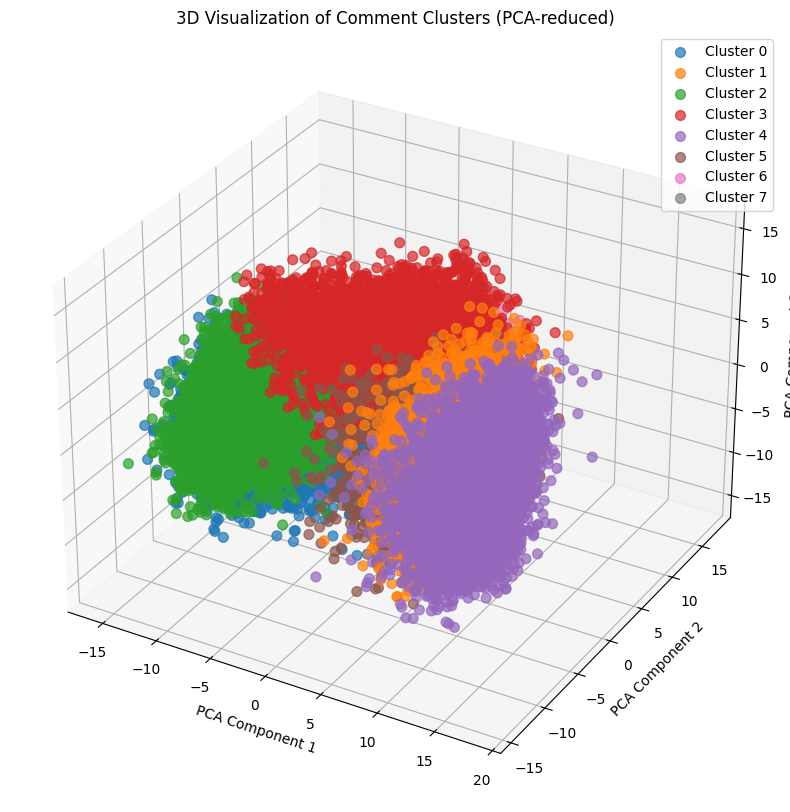

Clustering complete! Visualization saved as 'cluster_visualization_3d.png'
Cluster distribution:
cluster
0    3348
1    3100
2    4687
3    3067
4    4286
5    2130
6    6231
7    1350
Name: count, dtype: int64


In [ ]:
NUM_CLUSTERS = 8
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_embeddings)

# Reduce dimensions with PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with different color
for cluster_id in range(NUM_CLUSTERS):
    cluster_mask = (cluster_labels == cluster_id)
    ax.scatter(
        reduced_embeddings[cluster_mask, 0],
        reduced_embeddings[cluster_mask, 1],
        reduced_embeddings[cluster_mask, 2],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=50
    )

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Visualization of Comment Clusters (PCA-reduced)')
plt.legend()

# Save the plot
plt.savefig('cluster_visualization_3d.png', dpi=300, bbox_inches='tight')
plt.show()

# Add cluster labels to DataFrame
valid_idx = [i for i, emb in enumerate(embeddings) if emb is not None]
df.loc[valid_idx, 'cluster'] = cluster_labels
df['cluster'] = df['cluster'].fillna(-1).astype(int)

# Save results
print("Clustering complete! Visualization saved as 'cluster_visualization_3d.png'")
print("Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

In [ ]:
valid_embeddings = np.array([emb for emb in embeddings if emb is not None])
valid_indices = [i for i, emb in enumerate(embeddings) if emb is not None]  # Track original indices


# K-means clustering
NUM_CLUSTERS = 8
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_embeddings)

# Find and display 3 comments from each cluster
print("\nCluster analysis (3 representative comments per cluster):")
print("="*60)

for cluster_id in range(NUM_CLUSTERS):
    # Get indices of points in current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    if len(cluster_indices) == 0:
        print(f"\nCluster {cluster_id}: EMPTY CLUSTER")
        continue

    # Calculate distances to cluster center
    cluster_points = scaled_embeddings[cluster_indices]
    distances = np.linalg.norm(cluster_points - kmeans.cluster_centers_[cluster_id], axis=1)

    # Get 3 representative samples:
    # 1. Closest to centroid (most representative)
    closest_idx = np.argmin(distances)

    # 2. Random sample from cluster
    random_idx = np.random.choice(cluster_indices)

    # 3. Farthest from centroid (edge case)
    farthest_idx = np.argmax(distances)

    # Get original DataFrame indices
    original_indices = [
        valid_indices[cluster_indices[closest_idx]],
        valid_indices[random_idx],
        valid_indices[cluster_indices[farthest_idx]]
    ]

    # Get the texts
    sample_texts = df.iloc[original_indices]['text'].tolist()
    cluster_size = len(cluster_indices)

    # Print results
    print(f"\nCluster {cluster_id} (Size: {cluster_size}):")
    print("-"*60)
    print("1. [Most representative]")
    print(sample_texts[0])
    print("\n2. [Random sample]")
    print(sample_texts[1])
    print("\n3. [Edge case]")
    print(sample_texts[2])
    print("\n" + "="*60)

# Add cluster assignments back to DataFrame
df['cluster'] = -1  # Initialize with -1 for invalid embeddings
df.loc[valid_indices, 'cluster'] = cluster_labels



Cluster analysis (3 representative comments per cluster):

Cluster 0 (Size: 3348):
------------------------------------------------------------
1. [Most representative]
AOC called it... 


This is *transparently* evil. It's just evil. That's taxpayer money being reallocated from literally anything that helps taxpayers/humanity to Musk's pocket directly (tax cuts) and indirectly (defense spending). 


We're being *robbed*. By someone who has far, far more than enough money.  While my entire generation and younger can't buy homes and struggle to buy food. 


I'm at a level of rage I struggle to describe. This is monster behavior.

2. [Random sample]
It's literally a fire sale where he grabs as much loot as he can before his maga voters find out

3. [Edge case]
How do work requirements for Medicaid work for people who are permanently disabled?


Cluster 1 (Size: 3100):
------------------------------------------------------------
1. [Most representative]
Someone tell him that RB salaries 

Cluster-Topic Distribution (% per cluster):
label    r/gaming  r/nba  r/nfl  r/politics
cluster                                    
0            0.02   0.05   0.04        0.90
1            0.00   0.13   0.87        0.00
2            0.00   0.03   0.02        0.95
3            0.01   0.34   0.25        0.41
4            0.00   0.97   0.03        0.00
5            0.01   0.41   0.56        0.02
6            0.13   0.28   0.21        0.38
7            0.95   0.02   0.02        0.01


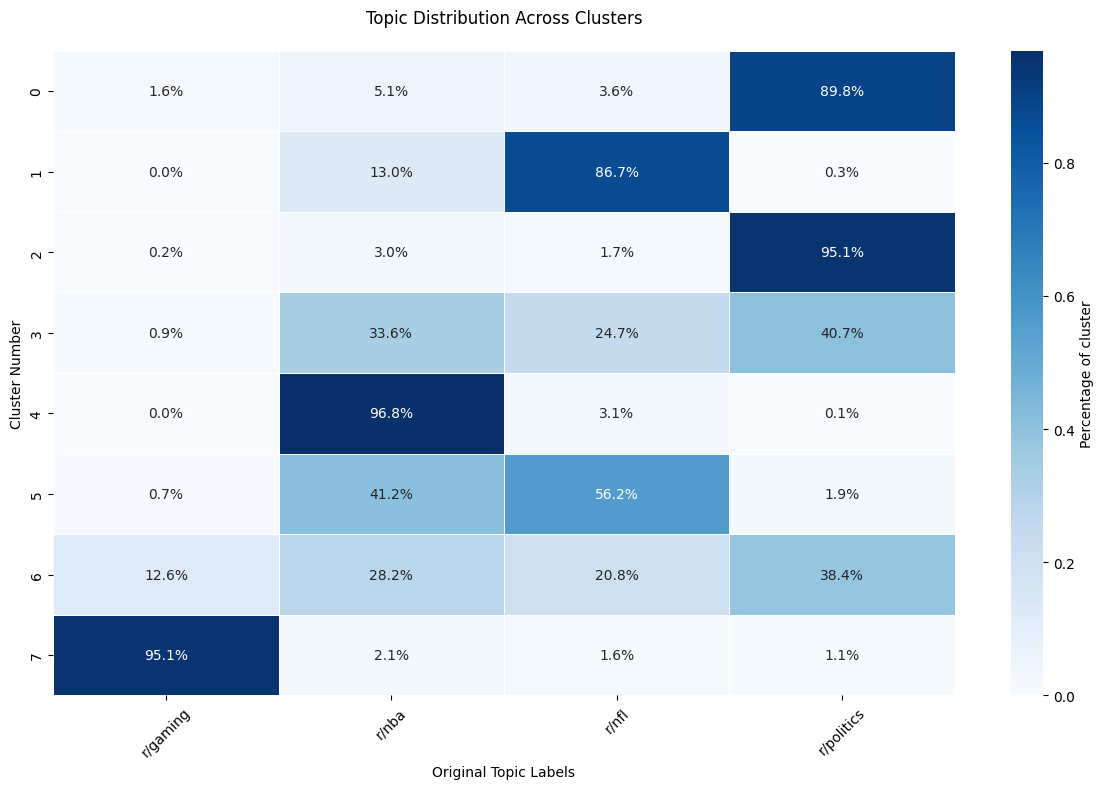


Dominant topics per cluster:
Cluster 0: r/politics (89.8%), r/nba (5.1%), r/nfl (3.6%)
Cluster 1: r/nfl (86.7%), r/nba (13.0%), r/politics (0.3%)
Cluster 2: r/politics (95.1%), r/nba (3.0%), r/nfl (1.7%)
Cluster 3: r/politics (40.7%), r/nba (33.6%), r/nfl (24.7%)
Cluster 4: r/nba (96.8%), r/nfl (3.1%), r/politics (0.1%)
Cluster 5: r/nfl (56.2%), r/nba (41.2%), r/politics (1.9%)
Cluster 6: r/politics (38.4%), r/nba (28.2%), r/nfl (20.8%)
Cluster 7: r/gaming (95.1%), r/nba (2.1%), r/nfl (1.6%)


In [ ]:
# Filter valid embeddings and get indices
valid_mask = df['embedding'].notna()
valid_embeddings = np.array(df[valid_mask]['embedding'].tolist())
valid_indices = df[valid_mask].index


kmeans = KMeans(n_clusters=8, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_embeddings)

# Add cluster assignments back to DataFrame
df['cluster'] = -1  # Initialize with -1
df.loc[valid_indices, 'cluster'] = cluster_labels

# Create cluster-topic matrix
def create_cluster_topic_matrix(df):
    # Cross-tabulation of clusters vs topics
    ct_matrix = pd.crosstab(
        index=df['cluster'],
        columns=df['label'],
        normalize='index'  # Show percentages per cluster
    )
    return ct_matrix

# Generate and display the matrix
ct_matrix = create_cluster_topic_matrix(df[df['cluster'] != -1])  # Exclude unclustered
print("Cluster-Topic Distribution (% per cluster):")
print(ct_matrix.round(2))

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    ct_matrix,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    cbar_kws={'label': 'Percentage of cluster'},
    linewidths=.5
)
plt.title('Topic Distribution Across Clusters', pad=20)
plt.xlabel('Original Topic Labels')
plt.ylabel('Cluster Number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cluster_topic_heatmap.png', dpi=300)
plt.show()

# Optional: Show top topics per cluster
print("\nDominant topics per cluster:")
for cluster in sorted(ct_matrix.index.unique()):
    top_topics = ct_matrix.loc[cluster].sort_values(ascending=False).head(3)
    print(f"Cluster {cluster}: {', '.join([f'{t} ({p:.1%})' for t,p in top_topics.items()])}")

🔍 Key Observations & Inferences
✅ Clear, well-separated clusters:

    Cluster 0: Dominated by r/politics (90%) → This is a pure politics cluster.

    Cluster 1: Contains 87% r/nfl and 13% r/nba → This is an NFL-focused cluster, possibly with some sports overlap.

    Cluster 2: 95% r/politics → Another politics-dominated cluster. Possibly different from Cluster 0 in tone or content (e.g., policy vs. social issues).

    Cluster 4: 97% r/nba → Very clean NBA cluster.

    Cluster 7: 95% r/gaming → Pure gaming content cluster.

These clusters are semantically tight and suggest good separation by topic.

 Mixed-content or ambiguous clusters:

    Cluster 3: 34% r/nba, 25% r/nfl, and 41% r/politics → Likely a mixed or transitional cluster, possibly about politicized sports or controversial issues in sports.

    Cluster 5: 41% r/nba, 56% r/nfl, minor politics → This may be a general sports cluster, with overlapping NBA/NFL content (e.g., cross-sport discussions, fantasy leagues, betting, etc.).

    Cluster 6: 13% r/gaming, 28% r/nba, 21% r/nfl, 38% r/politics → Very mixed. Possibly:

        Posts about social issues in games/sports

        Ambiguous texts (e.g., short comments, sarcasm)

        Generic phrasing that doesn't anchor to one topic well

💡 Implications

    The clustering algorithm performs very well for distinct topics (r/gaming, r/nba, r/nfl, r/politics).

    Some blended clusters suggest overlapping language or concepts across topics, especially between:

        Politics & sports (Cluster 3, 6)

        NBA & NFL (Cluster 5)

    Clusters 3 and 6 may warrant:

        Manual inspection of sample texts

        Additional preprocessing (e.g., keyword filtering, metadata)

        Possibly sub-clustering within them for better granularity

Cluster-Topic Count Matrix:

label    r/gaming  r/nba  r/nfl  r/politics
cluster                                    
0              53    170    120        3005
1               1    403   2688           8
2              11    139     80        4457
3              28   1032    759        1248
4               0   4149    134           3
5              15    877   1197          41
6             788   1759   1293        2391
7            1284     29     22          15


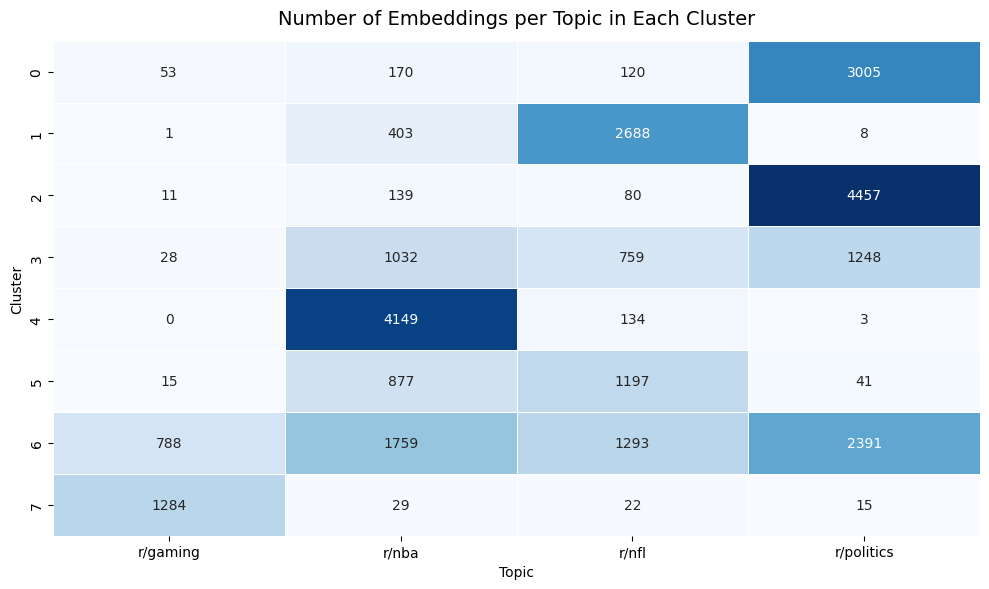

In [ ]:

df_filtered = df[df["cluster"] != -1]

topics = ["r/gaming", "r/nba", "r/nfl", "r/politics"]

# Create a pivot table (rows = clusters, columns = topics)
cluster_topic_counts = pd.crosstab(df_filtered["cluster"], df_filtered["label"])

# Reindex to show all expected topics, even if some are missing in data
cluster_topic_counts = cluster_topic_counts.reindex(columns=topics, fill_value=0)

# Show matrix
print("Cluster-Topic Count Matrix:\n")
print(cluster_topic_counts)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_topic_counts, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False)
plt.title("Number of Embeddings per Topic in Each Cluster", fontsize=14, pad=12)
plt.xlabel("Topic")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()



Inter-cluster distance matrix:

           Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
Cluster 0   0.000000   0.065256   0.019829   0.036844   0.070520   0.055694   
Cluster 1   0.065256   0.000000   0.066604   0.036943   0.035451   0.020654   
Cluster 2   0.019829   0.066604   0.000000   0.035198   0.071754   0.051095   
Cluster 3   0.036844   0.036943   0.035198   0.000000   0.042936   0.036305   
Cluster 4   0.070520   0.035451   0.071754   0.042936   0.000000   0.028896   
Cluster 5   0.055694   0.020654   0.051095   0.036305   0.028896   0.000000   
Cluster 6   0.030704   0.046468   0.031613   0.019463   0.047857   0.031494   
Cluster 7   0.062694   0.074251   0.067071   0.057359   0.075407   0.055731   

           Cluster 6  Cluster 7  
Cluster 0   0.030704   0.062694  
Cluster 1   0.046468   0.074251  
Cluster 2   0.031613   0.067071  
Cluster 3   0.019463   0.057359  
Cluster 4   0.047857   0.075407  
Cluster 5   0.031494   0.055731  
Cluster 6   0.000

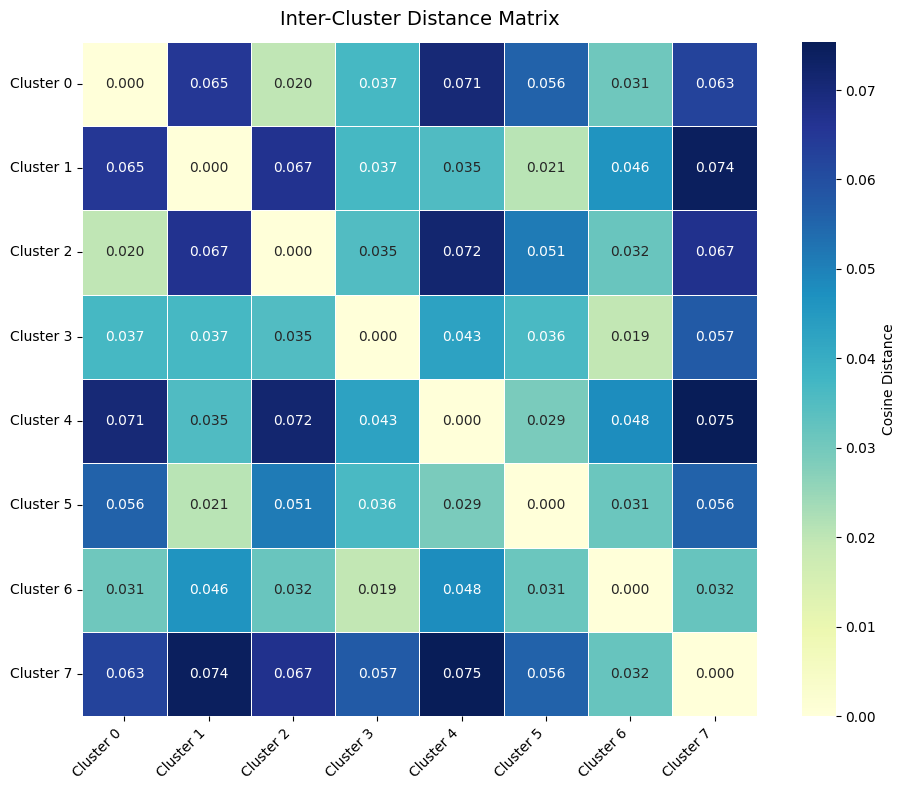

In [ ]:
from sklearn.metrics.pairwise import cosine_distances  # or euclidean_distances

# Ensure embeddings are parsed
df["embedding"] = df["embedding"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Filter out cluster -1 if using DBSCAN
valid_clusters = df[df["cluster"] != -1]
clusters = sorted(valid_clusters["cluster"].unique())

# Compute mean embeddings (centroids) for each cluster
cluster_means = []
for cluster_id in clusters:
    cluster_embeddings_raw = valid_clusters[valid_clusters["cluster"] == cluster_id]["embedding"].tolist()
    cluster_embeddings = [e if isinstance(e, list) else json.loads(e) for e in cluster_embeddings_raw]
    cluster_mean = np.mean(np.array(cluster_embeddings, dtype=np.float32), axis=0)
    cluster_means.append(cluster_mean)

cluster_means = np.array(cluster_means)

# Compute pairwise cosine distances (1 - cosine similarity)
distance_matrix = cosine_distances(cluster_means)

# Convert to DataFrame for labeling
distance_df = pd.DataFrame(
    distance_matrix,
    index=[f"Cluster {i}" for i in clusters],
    columns=[f"Cluster {i}" for i in clusters]
)

# Print matrix
print("\nInter-cluster distance matrix:\n")
print(distance_df)

# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    distance_df,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Cosine Distance"}
)
plt.title("Inter-Cluster Distance Matrix", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## SCALE THE DISTANCES

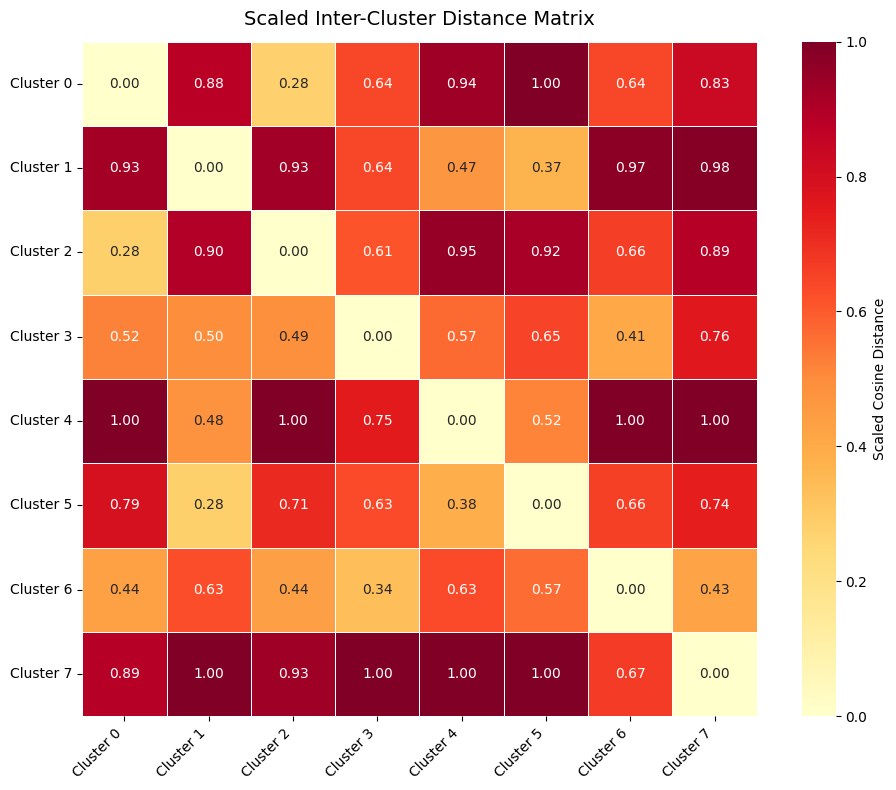

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming `distance_matrix` and `clusters` are already computed

# Scale the distances to [0, 1] for better heatmap contrast
scaler = MinMaxScaler()
distance_scaled = scaler.fit_transform(distance_matrix)

# Create a labeled DataFrame for the heatmap
distance_df_scaled = pd.DataFrame(
    distance_scaled,
    index=[f"Cluster {i}" for i in clusters],
    columns=[f"Cluster {i}" for i in clusters]
)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    distance_df_scaled,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Scaled Cosine Distance"}
)
plt.title("Scaled Inter-Cluster Distance Matrix", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


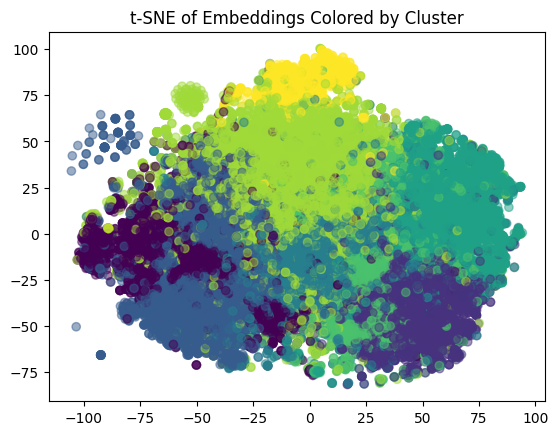

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(scaled_embeddings)

plt.scatter(emb_2d[:,0], emb_2d[:,1], c=cluster_labels, alpha=0.5)
plt.title("t-SNE of Embeddings Colored by Cluster")
plt.show()